# Milestone 1 : Regression - Predicting seismic collapse capacity

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import metrics

import time

import pickle

import sys


## 1.Data

### 1.1 Import

In [2]:
df = {}
for t in ['train', 'test', 'val'] :
    df[t] = pd.read_csv(f"Data/{t}_set.csv")
df['train'].head(5)

,0.01,0.02,0.022,0.025,0.029,0.03,0.032,0.035,0.036,0.04,...,8.5,9.0,9.5,10.0,sa_avg,da5_75,da5_95,fiv3,sa_ratio,sat1_col
0,0.011075,0.011107,0.011132,0.011176,0.011274,0.011288,0.011341,0.011377,0.011422,0.011567,...,0.000247,0.000223,0.000206,0.000190,0.010809,14.484,21.416,2.881797,0.832237,0.78
1,0.155380,0.153050,0.154590,0.156281,0.161038,0.160171,0.159765,0.166164,0.173643,0.174708,...,0.002316,0.002225,0.002106,0.001998,0.031044,14.430,18.270,7.642059,0.961638,1.96
2,0.060774,0.060783,0.060790,0.060795,0.060799,0.060800,0.060804,0.060794,0.060793,0.060798,...,0.013225,0.012226,0.011904,0.011696,0.098425,16.700,35.105,42.218868,1.737888,1.39
3,0.016016,0.016088,0.016106,0.016135,0.016198,0.016218,0.016263,0.016401,0.016445,0.016595,...,0.000192,0.000163,0.000139,0.000124,0.010169,7.320,17.370,2.599605,1.000551,1.97
4,0.030632,0.030699,0.030724,0.030738,0.030785,0.030809,0.030811,0.030818,0.030856,0.031014,...,0.004094,0.003350,0.002638,0.002224,0.037375,28.005,41.635,11.434507,1.371310,1.43


#### Columns options :

In [3]:
X_col = {}
y_col = ['sat1_col']
#Option 1 : All
X_col["All"] = df['test'].columns.to_numpy()
#Option 2 : Reduce to last columns (no sa(T), only the other columns. sa_ratio and sa_avg is there to convey the sa information)
X_col["Reduced"] = ['1.3','sa_avg','da5_75', 'da5_95', 'fiv3', 'sa_ratio']
#Option 3 : Best 15 cols (section 7.)
X_col['Best_15'] = ['sa_avg', 'fiv3', 'da5_95', '0.06', '0.1', 'max_period', 'da5_75', '1.5', '0.07'
, '0.34', '0.32', '0.03', '0.4', '0.13', '9.0']

### Data Expansion : Max Period

In [4]:
for t in ['train', 'test', 'val'] :
    df[t]['max_period'] = df[t][df['test'].columns.difference(X_col["Reduced"]+["max_period"])].idxmax(axis="columns").astype("float")

In [5]:
df['val']['max_period']

0       0.190
1       0.500
2       0.420
3       0.600
4       0.180
        ...  
1495    0.133
1496    0.220
1497    0.320
1498    0.500
1499    0.280
Name: max_period, Length: 1500, dtype: float64

In [6]:
#Option 3 and 3.1 : Add max_period
X_col["Red_max_period"] = ['sa_avg','da5_75', 'da5_95', 'fiv3', 'sa_ratio', 'max_period']
X_col["All_max_period"] = df['test'].columns.to_numpy()

### Choice of parameters

In [7]:
#Choix :
columns = "All_max_period"

In [8]:
X_train = df['train'][X_col[columns]].to_numpy()
y_train = df['train'][y_col].to_numpy()

X_val = df['val'][X_col[columns]].to_numpy()
y_val = df['val'][y_col].to_numpy()

X_test = df['test'][X_col[columns]].to_numpy()

cols_map = np.array(X_col[columns])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(cols_map)

(12646, 111)
(3000, 111)
(1500, 111)
['0.01' '0.02' '0.022' '0.025' '0.029' '0.03' '0.032' '0.035' '0.036'
 '0.04' '0.042' '0.044' '0.045' '0.046' '0.048' '0.05' '0.055' '0.06'
 '0.065' '0.067' '0.07' '0.075' '0.08' '0.085' '0.09' '0.095' '0.1' '0.11'
 '0.12' '0.13' '0.133' '0.14' '0.15' '0.16' '0.17' '0.18' '0.19' '0.2'
 '0.22' '0.24' '0.25' '0.26' '0.28' '0.29' '0.3' '0.32' '0.34' '0.35'
 '0.36' '0.38' '0.4' '0.42' '0.44' '0.45' '0.46' '0.48' '0.5' '0.55' '0.6'
 '0.65' '0.667' '0.7' '0.75' '0.8' '0.85' '0.9' '0.95' '1.0' '1.1' '1.2'
 '1.3' '1.4' '1.5' '1.6' '1.7' '1.8' '1.9' '2.0' '2.2' '2.4' '2.5' '2.6'
 '2.8' '3.0' '3.2' '3.4' '3.5' '3.6' '3.8' '4.0' '4.2' '4.4' '4.6' '4.8'
 '5.0' '5.5' '6.0' '6.5' '7.0' '7.5' '8.0' '8.5' '9.0' '9.5' '10.0'
 'sa_avg' 'da5_75' 'da5_95' 'fiv3' 'sa_ratio' 'max_period']


### 1.2 Normalisation

In [9]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

def Normalise(X):
    return (X-mean)/std

X_train = Normalise(X_train)
X_val = Normalise(X_val)
X_test = Normalise(X_test)



### 1.3 Import en Pytorch

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

In [10]:
def convert_to_dataloader(x, y=None, batch_size = 100):
    tensor_x = torch.Tensor(x)
    try:
        if y == None:
            dataset = torch.utils.data.TensorDataset(tensor_x)
    except:
        tensor_y = torch.Tensor(y)
        dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    return torch.utils.data.DataLoader(dataset, batch_size = batch_size)

dataload_train = convert_to_dataloader(X_train, y_train)
dataload_val = convert_to_dataloader(X_val, y_val)
dataload_test = convert_to_dataloader(X_test)

## 2. Models

### 2.1 OneLayerNet

In [11]:
class OneLayerNet(nn.Module):
    """1-Layer linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

one_layer_net = OneLayerNet(X_train.shape[1])

### 2.2 ThreeLayerNet

In [12]:
class ThreeLayerNet(nn.Module):
    """3-Layer linear+RELU"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

three_layer_net = ThreeLayerNet(X_train.shape[1])

### 2.3 FourLayerNet

In [13]:
class FourLayerNet(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(2*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.gelu(x))
        x2 = x**2
        x = torch.stack([x, x2], dim=2).flatten(start_dim=1) # Adding x^2 terms
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net = FourLayerNet(X_train.shape[1])

### 2.4 NonLinearNet

Very Bad Result : Loss goes in dent de scie

In [14]:
class NonLinearNet(nn.Module):
    """Non-linear (first)"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//4)
        self.fc2 = nn.Linear(4*(cols//4), cols//2)
        self.fc3 = nn.Linear(cols//2, cols//8)
        self.fc4 = nn.Linear(cols//8, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.stack([x, x**2, torch.log(x+1e-3), torch.exp(x)], dim=2).flatten(start_dim=1) # Adding x^2, log, exp terms
        x = self.fc2(F.gelu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

non_linear_net = NonLinearNet(X_train.shape[1])

In [15]:
class NonLinearNet2(nn.Module):
    """Non-linear (second)"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(3*cols, cols)
        self.fc2 = nn.Linear(cols, cols//2)
        self.fc3 = nn.Linear(cols//2, cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x2 = torch.hstack((x[:,1:]*x[:,:-1], (x[:,1]*x[:,-1]).view(-1,1))) #xy terms
        x = torch.hstack([x, x**2, x2]) #Adding x^2, xy terms
        x = self.fc1(x)
        x = self.fc2(F.gelu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

non_linear_net2 = NonLinearNet2(X_train.shape[1])

### 2.5 FourLayerNet3

In [16]:
class FourLayerNet3(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(4*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.gelu(x))
        x2 = x**2
        x3 = x**3
        x4 = x**4
        x = torch.stack([x, x2, x3, x4], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net3 = FourLayerNet3(X_train.shape[1])

### 2.6 TwoLayer

In [17]:
class TwoLayerNet(nn.Module):
    """2-Layer linear+RELU"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//6)
        self.fc2 = nn.Linear(cols//6, 1)
     

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

two_layer_net = TwoLayerNet(X_train.shape[1])

#works well with SGD
# optimizer = optim.SGD(model.parameters(), lr=0.0001) and epoch 1000 


### 2.7 FiveLayerNetRacine

In [18]:
class FiveLayerNetRacine(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.norm2 = torch.nn.BatchNorm1d(2*(cols//4))
        self.fc3 = nn.Linear(2*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x = torch.stack([x, x2], dim=2).flatten(start_dim=1) # Adding x^2 terms
        x = self.norm2(x)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

five_layer_net_racine = FiveLayerNetRacine(X_train.shape[1])

### 2.8 FourLayerNetTwoThree

In [19]:
class FourLayerNetTwoThree(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(4*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x3 = x**2
        x4 = x**3
        x = torch.stack([x, x2, x3, x4], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net_two_three = FourLayerNetTwoThree(X_train.shape[1])

### 2.8 FourLayerNetTwo

In [20]:
# With a Racine and a Square
class FourLayerNetTwo(nn.Module):
    """4-Layer linear+RELU + Non-linear"""
    
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(3*(cols//4), cols//4)
        self.fc4 = nn.Linear(cols//4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x2 = x.sign() * torch.sqrt(x.abs())
        x3 = x**2
        x = torch.stack([x, x2, x3], dim=2).flatten(start_dim=1)
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

four_layer_net_two_three = FourLayerNetTwoThree(X_train.shape[1])

### EightLayerNet

In [21]:
class EightLayerNet(nn.Module):
    def __init__(self, cols):
        super().__init__()
        self.fc1 = nn.Linear(cols, cols//2)
        self.fc2 = nn.Linear(cols//2, cols//4)
        self.fc3 = nn.Linear(cols//4, cols//6)
        self.fc4 = nn.Linear(cols//6, cols//10)
        self.fc5 = nn.Linear(cols//10 , cols//16)
        self.fc6 = nn.Linear(cols//16 , cols//20)
        self.fc7 = nn.Linear(cols//20 , cols//24)
        self.fc8 = nn.Linear(cols//24 , 1)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        x = self.fc5(F.relu(x))
        x = self.fc6(F.relu(x))
        x = self.fc7(F.relu(x))
        x = self.fc8(F.relu(x))
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self.forward(x)
        return y

eight_layer_net = EightLayerNet(X_train.shape[1])
#With adamW loss 0.1458 - 30 epochs 

## 3. Training

### 3.1 Loss function

In [22]:
loss_fn = nn.MSELoss(reduction="mean")

### 3.2 Training, test, export routine

In [23]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):

    model.eval()
    losses = []
    
    with torch.no_grad():
        for data, target in dataloader:
            # Forward pass
            out = model(data)
            
            losses.append(loss_fn(out,target).item())
        ### END CODE HERE ###
            
    return np.mean(losses)

In [24]:
def export_test(model, prefix = "", suffix = time.time()):
    model_name = model.__repr__().split('(')[0]
    y_test = model(torch.Tensor(X_test))
    df_out = pd.DataFrame(y_test.detach().numpy())
    df_out.columns = ['sat1_col']
    df_out.to_csv(f"submissions_Joking/{prefix}{model_name}_{suffix}.csv", index=False)

In [25]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int, do_be_printing = True, id=""):
    
    # Initialize metrics for loss and accuracy
    #loss_metric = metrics.LossMetric()
    losses_train = []
    losses_val = []
    
    # Sets the module in training mode (doesn't have any effect here, but good habit to take)
    model.train()
    
    for epoch in range(1, epochs + 1):
        losses = []
        # Progress bar set-up
        #pbar = tqdm(total=len(train_loader), leave=True)
        #pbar.set_description(f"Epoch {epoch}")
        
        # Iterate through data
        for data, target in train_loader:
            
            ### START CODE HERE ###
            
            # Zero-out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data)
            
            # Compute loss
            loss = loss_fn(out, target)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            ### END CODE HERE ###
            
            # Update metrics & progress bar
            #loss_metric.update(loss.item(), data.shape[0])
            #pbar.update()
            losses.append(loss.item())
            
        # End of epoch, show loss and acc
        #pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Train acc: {acc_metric.compute() * 100:.2f}%")
        #print(f"Train loss: {loss_metric.compute():.3f}")
        #loss_metric.reset()

        val_loss = test(model, dataload_val)
        train_loss = np.mean(losses)
        
        losses_train.append(train_loss)
        losses_val.append(val_loss)
        if epoch % 10 == 0:
            if do_be_printing:
                print(epoch, train_loss, val_loss)
            if(np.mean(losses_val[-5:])-0.02 > np.mean(losses_val[-10:])):
                return
            if val_loss < 0.16:
                export_test(model, "sapin", f"{val_loss:.3f}_{str(optimizer).split()[0]}{id}")
        else:
            if do_be_printing:
                print(epoch, train_loss)

    return losses_train, losses_val

In [39]:
model = EightLayerNet(X_train.shape[1])
#optimizer = optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
train(model, dataload_train, loss_fn, optimizer, epochs=20, do_be_printing=False)

NameError: name 'optimizer' is not defined

## 4. Choosing Best Model 

### 4.1 Functions

#### To run all models

In [26]:
def save(val_loss):
    f= open("history.txt", "a+")
    f.write(f"""
    ------------

    {model}

    Columns : {columns}
    VAL LOSS : {val_loss}""")
    f.close()

In [27]:
def save_object(obj, filename="result_all_models"):
    with open(f"{filename}.pkl", 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
    np.save(f"{filename}.npy", obj) 

def recover_result(filename):
    with open(f"{filename}.pkl", 'rb') as input:
        obj = pickle.load(input)
    return obj

In [28]:
def testing_all_models(models, optims, n_epochs, id=False):
    exports = {}
    for Model in models:   
        i=0
        for Optim, kargs in optims:
            model = Model(X_train.shape[1])
            optimizer = Optim(model.parameters(), **kargs)
            name = str(model).split("(")[0] + " - " + str(optimizer).split()[0]
            if id:
                i+=1
                name=name+str(i)
            try:
                loss_train, val_loss = train(model, dataload_train, loss_fn, optimizer, epochs=n_epochs, do_be_printing = False, id=i)
                exports[name] = (model, loss_train, val_loss)
                print(f"{name} : {np.min([loss_train, val_loss], axis=1)}")
                save(np.min(val_loss))
            except:
                print(f"{name} : failed {sys.exc_info()[0]}")
    return exports

#### To analyse the results

In [29]:
def plot_losses(result):
    n = len(result)
    cols = np.min([int(n**0.5), 5])
    rows = int(n//cols )+1
    plt.figure(figsize=(20,40))
    i = 0

    for name, data in result.items():
        i+=1
        x = np.arange(0,len(data[1]))
        plt.subplot(rows, cols, i)
        plt.plot(x, data[1], label = f"train")
        plt.plot(x, data[2], label = f"val")
        plt.title(name)
        plt.ylim([0.1,0.2])
        plt.legend()
        
    #Show losses progress
    plt.show()

In [30]:
def get_df_from_results(result):
    dataout = []

    for name, data in result.items():
        best_epoch = np.argmin(data[2])
        model, optimiser = tuple(name.split(" - "))
        best_val_loss = np.min(data[2])
        best_train_loss = np.min(data[1])

        dataout.append([model, optimiser, best_train_loss, best_val_loss, best_epoch])
    
    dataout = np.array(dataout)
    index=  pd.MultiIndex.from_arrays([dataout[:,0],dataout[:,1]], names = ["model", "optimiser"])
    df = pd.DataFrame(dataout[:, 2:], index = index, columns = ['best train loss', 'best val loss', 'best epoch'], dtype='float')
    return df

### 4.2 Analyse

Let's start by running all models with all optimisers with default values

In [ ]:
models = [ThreeLayerNet, FourLayerNet, NonLinearNet, FourLayerNet3, TwoLayerNet, FiveLayerNetRacine, FourLayerNetTwoThree, EightLayerNet, ]
optims = [(torch.optim.SGD, {"lr":1e-3}),
            (torch.optim.Adadelta, {}),
            (torch.optim.Adagrad, {}),
            (torch.optim.Adam, {}),
            (torch.optim.AdamW, {}),
            (torch.optim.Adamax, {}),
            (torch.optim.LBFGS, {}),
            (torch.optim.RMSprop, {}),
            (torch.optim.ASGD, {}),
            (torch.optim.Rprop, {})]
result = testing_all_models(models, optims, 0) #We ran it with 100 epochs
save_object(result, f"result_{time.time()}") #Save result object for analysis later on.

ThreeLayerNet - SGD : failed <class 'ValueError'>
ThreeLayerNet - Adadelta : failed <class 'ValueError'>
ThreeLayerNet - Adagrad : failed <class 'ValueError'>
ThreeLayerNet - Adam : failed <class 'ValueError'>
ThreeLayerNet - AdamW : failed <class 'ValueError'>
ThreeLayerNet - Adamax : failed <class 'ValueError'>
ThreeLayerNet - LBFGS : failed <class 'ValueError'>
ThreeLayerNet - RMSprop : failed <class 'ValueError'>
ThreeLayerNet - ASGD : failed <class 'ValueError'>
ThreeLayerNet - Rprop : failed <class 'ValueError'>
FourLayerNet - SGD : failed <class 'ValueError'>
FourLayerNet - Adadelta : failed <class 'ValueError'>
FourLayerNet - Adagrad : failed <class 'ValueError'>
FourLayerNet - Adam : failed <class 'ValueError'>
FourLayerNet - AdamW : failed <class 'ValueError'>
FourLayerNet - Adamax : failed <class 'ValueError'>
FourLayerNet - LBFGS : failed <class 'ValueError'>
FourLayerNet - RMSprop : failed <class 'ValueError'>
FourLayerNet - ASGD : failed <class 'ValueError'>
FourLayerNet 

In [ ]:
#Recovering results from file
result = recover_result('result_arbre.pkl')

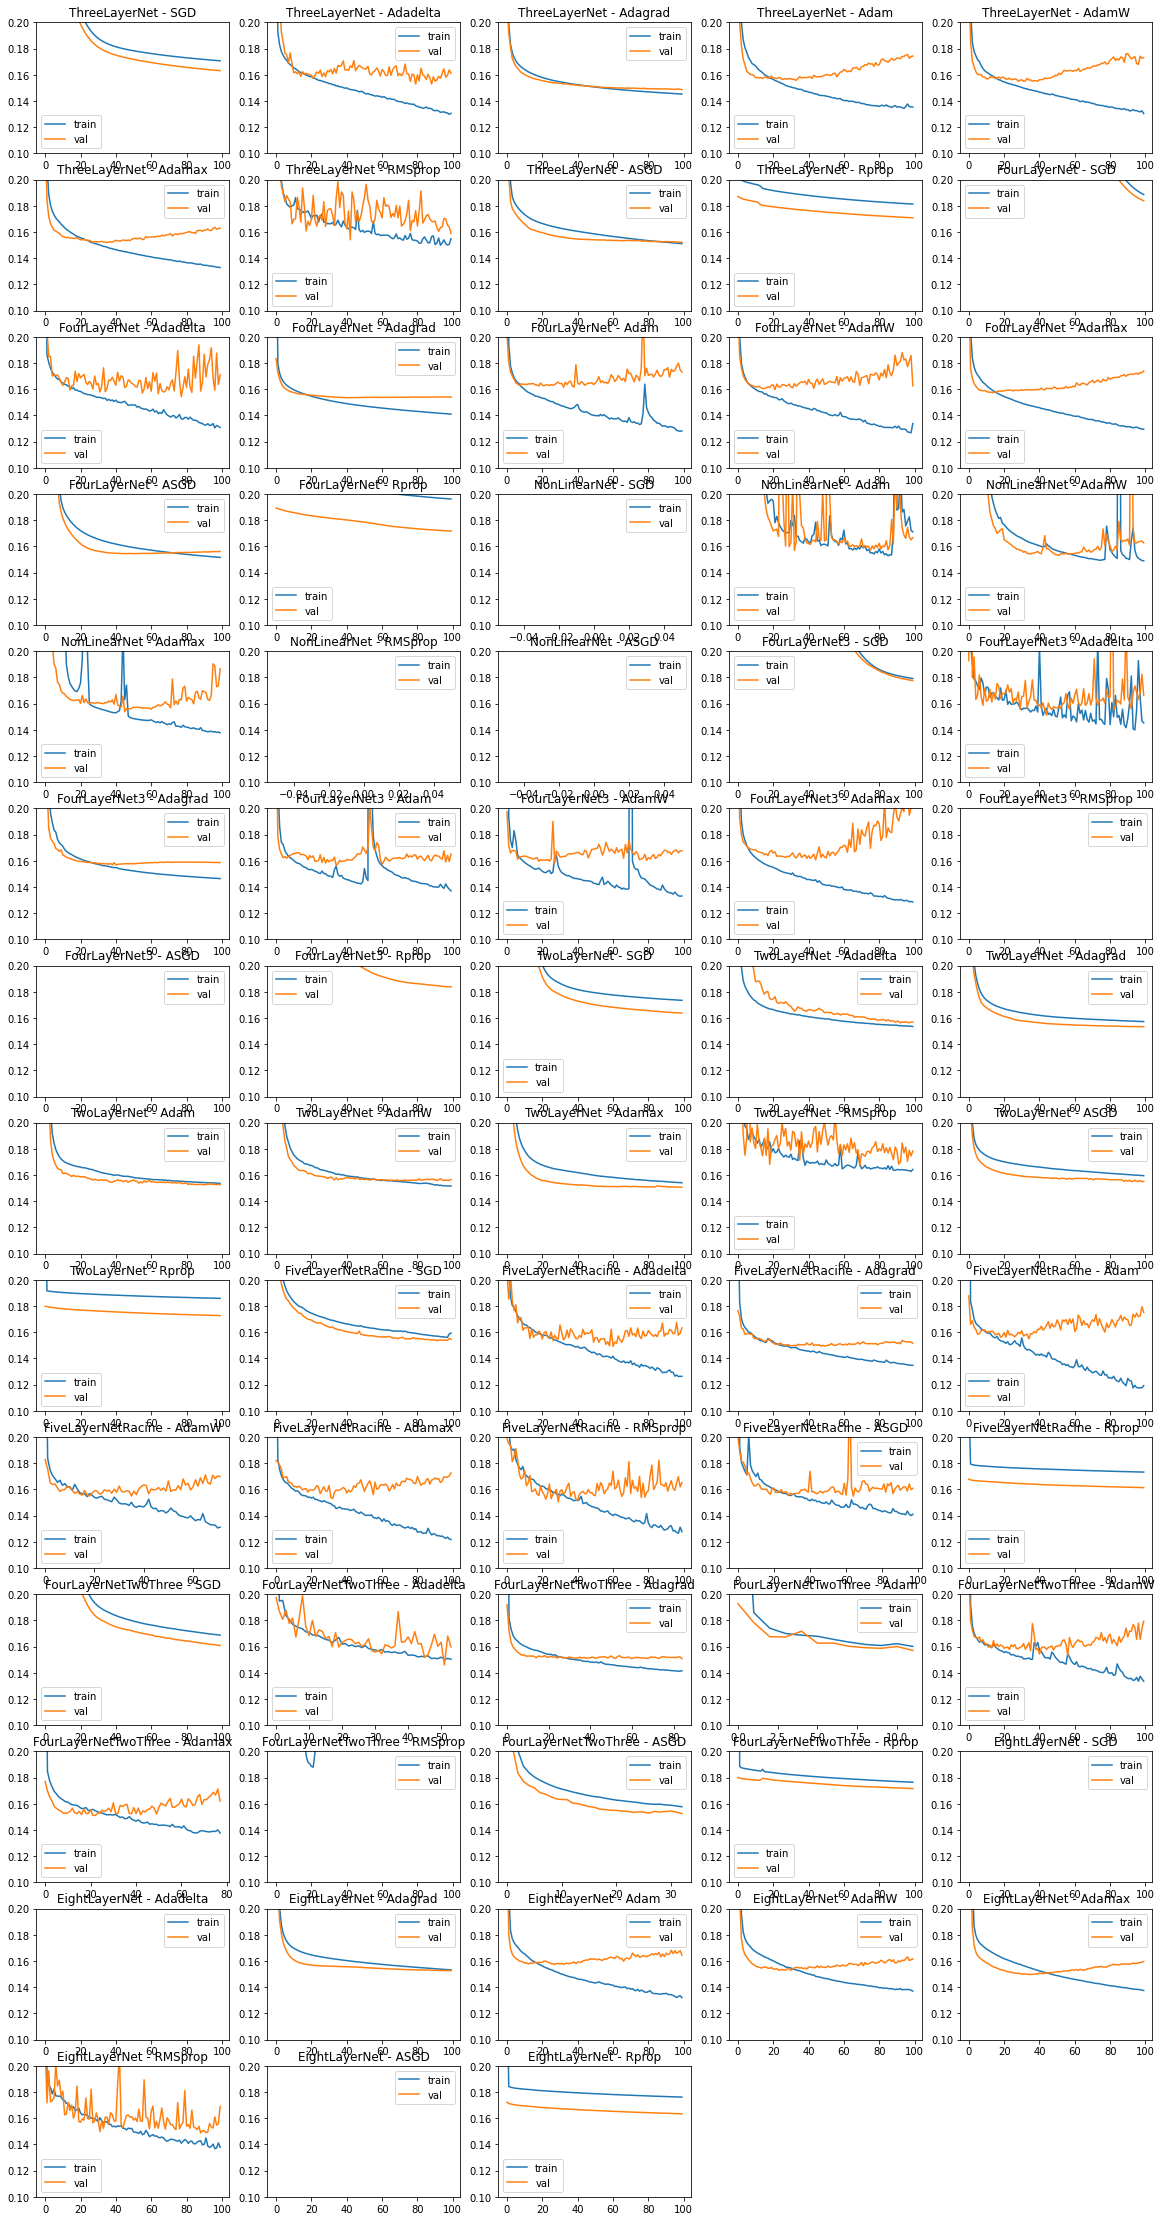

In [ ]:
#Plot losses evolution for each :
plot_losses(result)

In [ ]:
#Get a df with result of each run :
df = get_df_from_results(result)

<AxesSubplot:title={'center':'Best Epoch'}, ylabel='Frequency'>

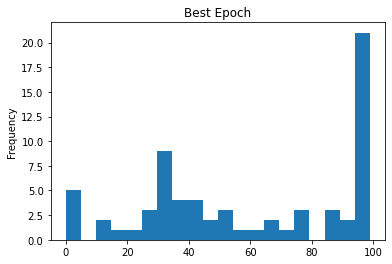

In [ ]:
df["best epoch"].plot.hist(bins=20, title="Best Epoch")

On observe deux comportements principaux : Soit la meilleure époque est autour de 30, soit elle est à 99.

Nous allons séparer ces deux groupes de modèles :

#### A. Best epoch ~ 30

In [ ]:
df_30 = df[df["best epoch"]>25][df["best epoch"] < 40][df["best val loss"]<0.155]
df_30

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


best train loss  best val loss  best epoch
model              optimiser                                            
ThreeLayerNet      Adamax            0.132853       0.151937        35.0
FiveLayerNetRacine Adamax            0.121776       0.153018        32.0
                   RMSprop           0.126546       0.150464        29.0
EightLayerNet      AdamW             0.137022       0.152848        30.0
                   Adamax            0.137505       0.149797        35.0

On va maintenant travailler sur les paramètres des optimisers

In [ ]:
models = [ThreeLayerNet, FiveLayerNetRacine, EightLayerNet]
optims = [  (torch.optim.Adamax, {"lr":0.002, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}), #Default, for control
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}),
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0.1}),
            (torch.optim.Adamax, {"lr":0.002, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.1}),
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.9, 0.99), "eps":1e-08, "weight_decay":0}),
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}),
            (torch.optim.RMSprop, {}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.005, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.001, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.0005, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.95, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.9, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0.1, "momentum":0, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0.1, "centered":False}),
            (torch.optim.RMSprop, {"lr":0.01, "alpha":0.99, "eps":1e-08, "weight_decay":0, "momentum":0, "centered":True}),
            ]
result = testing_all_models(models, optims, 100, id=True)
save_object(result, f"result_best30_") #Save result object for analysis later on.

ThreeLayerNet - Adamax1 : [0.13118115 0.15390447]
ThreeLayerNet - Adamax1 : failed <class 'NameError'>
ThreeLayerNet - Adamax2 : [0.13887522 0.14974951]
ThreeLayerNet - Adamax2 : failed <class 'NameError'>
ThreeLayerNet - Adamax3 : [0.18370926 0.17570801]
ThreeLayerNet - Adamax3 : failed <class 'NameError'>
ThreeLayerNet - Adamax4 : [0.18414134 0.17651136]
ThreeLayerNet - Adamax4 : failed <class 'NameError'>
ThreeLayerNet - Adamax5 : [0.1388607 0.1522137]
ThreeLayerNet - Adamax5 : failed <class 'NameError'>
ThreeLayerNet - Adamax6 : [0.14557655 0.15000873]
ThreeLayerNet - Adamax6 : failed <class 'NameError'>
ThreeLayerNet - RMSprop7 : [0.15126778 0.15785648]
ThreeLayerNet - RMSprop7 : failed <class 'NameError'>
ThreeLayerNet - RMSprop8 : [0.14927496 0.15330111]
ThreeLayerNet - RMSprop8 : failed <class 'NameError'>
ThreeLayerNet - RMSprop9 : [0.13056372 0.15392808]
ThreeLayerNet - RMSprop9 : failed <class 'NameError'>
ThreeLayerNet - RMSprop10 : [0.13331843 0.15910238]
ThreeLayerNet - R

In [ ]:
#récupération des résultats :
result = recover_result("result_best30")

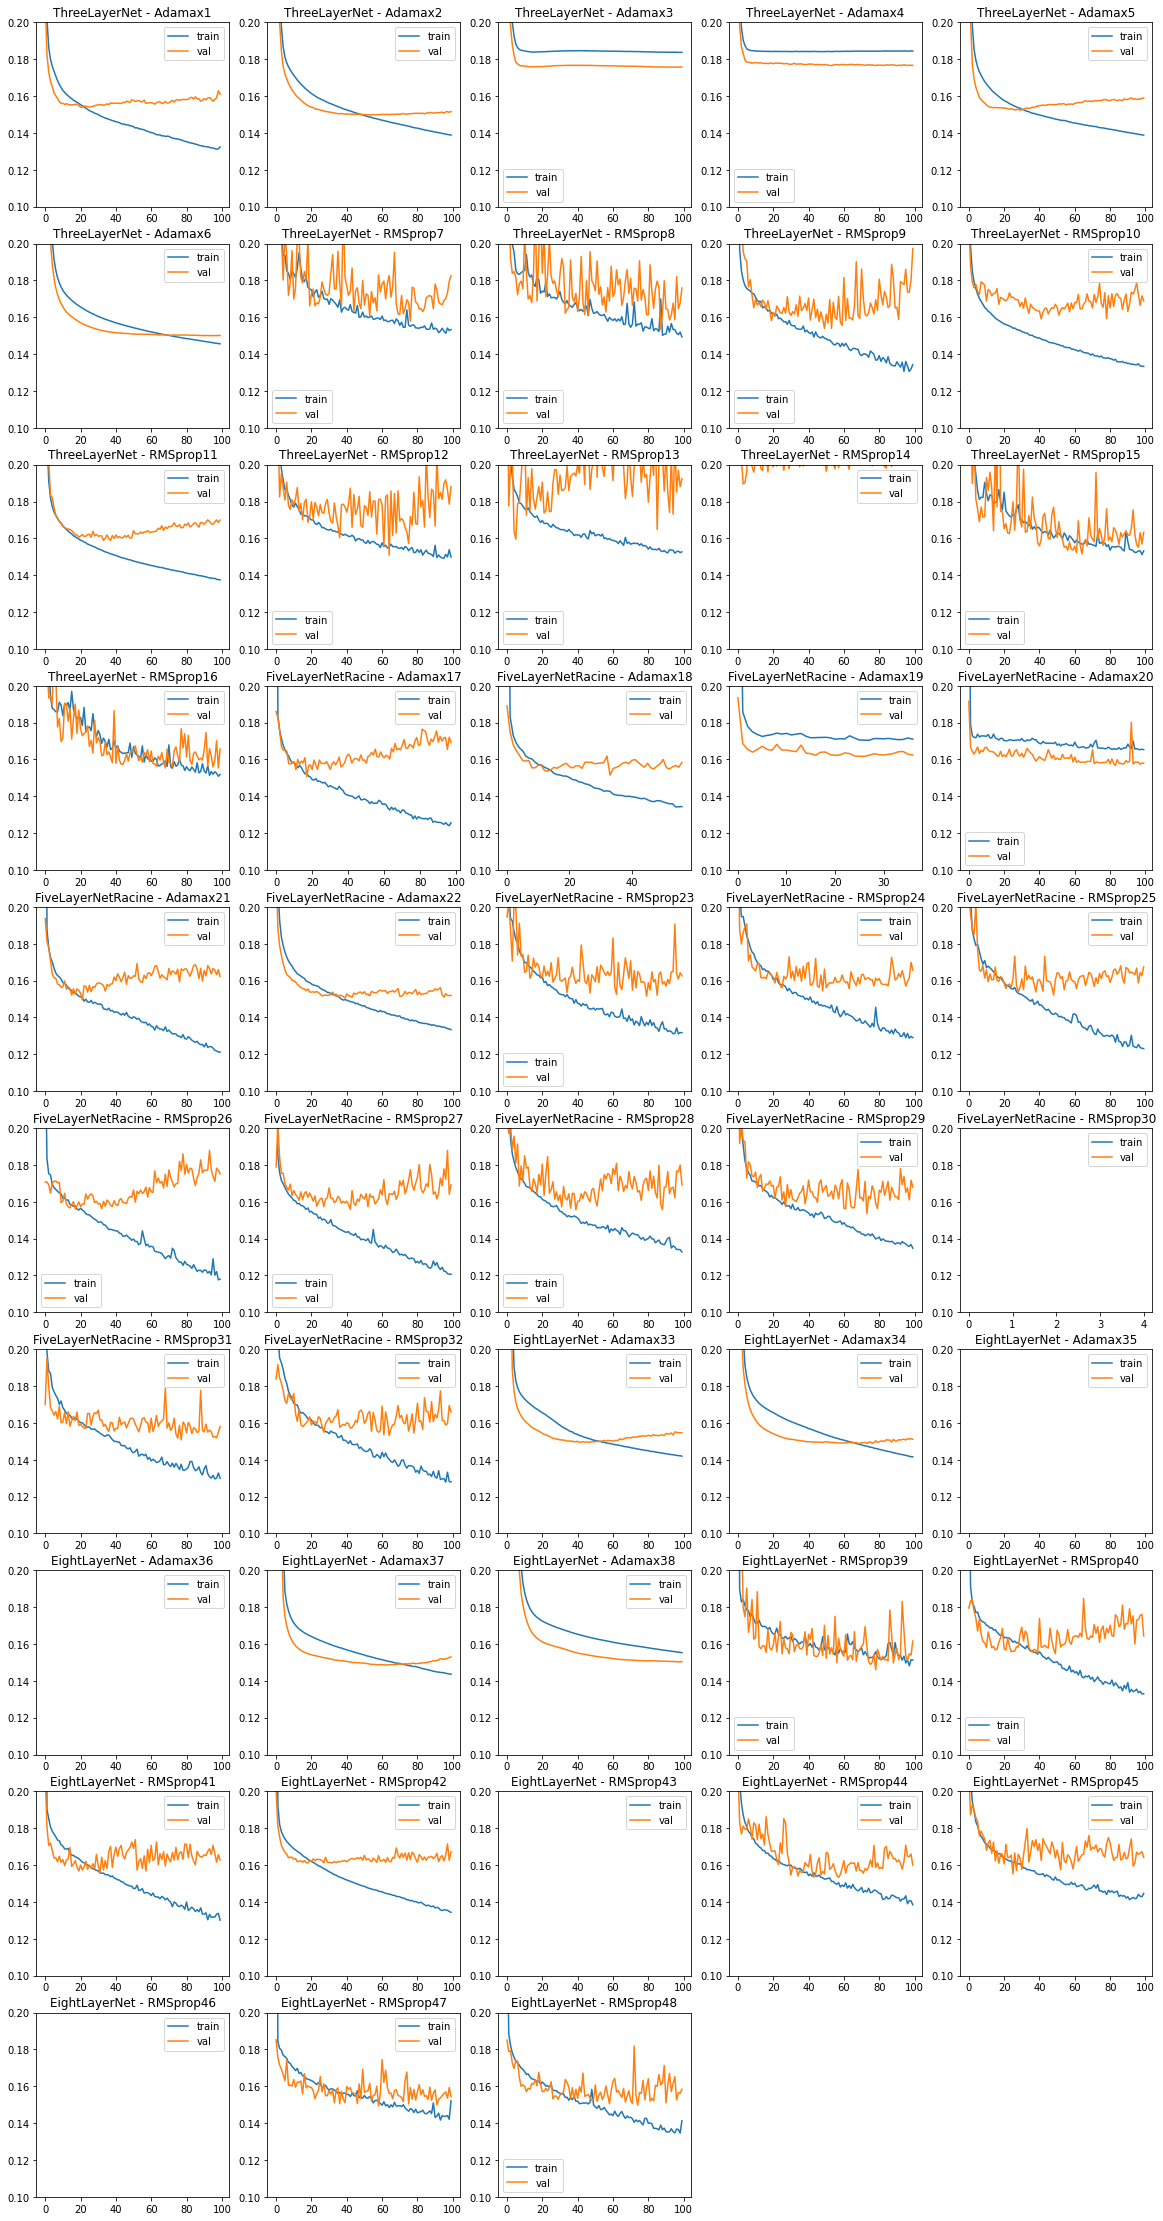

In [ ]:
plot_losses(result)

In [ ]:
df = get_df_from_results(result)
df.head(5)

best train loss  best val loss  best epoch
model         optimiser                                            
ThreeLayerNet Adamax1           0.131181       0.153904        21.0
              Adamax2           0.138875       0.149750        53.0
              Adamax3           0.183709       0.175708        95.0
              Adamax4           0.184141       0.176511        53.0
              Adamax5           0.138861       0.152214        29.0

In [ ]:
df.sort_values("best val loss").head(10)

best train loss  best val loss  best epoch
model              optimiser                                            
EightLayerNet      RMSprop39         0.148155       0.146014        78.0
                   Adamax37          0.143621       0.148588        63.0
                   Adamax34          0.141558       0.148794        69.0
                   RMSprop47         0.141605       0.149307        58.0
                   Adamax33          0.141909       0.149378        41.0
FiveLayerNetRacine Adamax21          0.121184       0.149540        21.0
EightLayerNet      RMSprop48         0.134542       0.149667        74.0
ThreeLayerNet      Adamax2           0.138875       0.149750        53.0
                   Adamax6           0.145577       0.150009        93.0
EightLayerNet      Adamax38          0.155285       0.150277        98.0

We will avoid RMSprop because it is very unstable. Also, it didn't really improve

Adamax got better on the EightLayerNet when we reduced the first beta, added weight decay and when we reduced the betas. Let's continue :


In [31]:
models = [EightLayerNet]
optims = [  (torch.optim.Adamax, {"lr":0.002, "betas":(0.9, 0.999), "eps":1e-08, "weight_decay":0}), #Default, for control
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),  #2
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),   #3
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0}), #4
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),   #5
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),    #6
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0}),  #7
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),  #8
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),   #9
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.01}), #10
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),   #11
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),    #12
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.01}),  #13
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.1}),  #14
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.1}),   #15
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.1}), #16
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.1}),   #17
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.1}),    #18
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.1}),  #19
            ]
result = testing_all_models(models, optims, 100, id=True)
save_object(result, f"result_8Layer_Adamax") #Save result object for analysis later on.

EightLayerNet - Adamax1 : [0.31253045 0.29734713]
EightLayerNet - Adamax1 : failed <class 'NameError'>
EightLayerNet - Adamax2 : [0.14127665 0.1537894 ]
EightLayerNet - Adamax2 : failed <class 'NameError'>
EightLayerNet - Adamax3 : [0.13742118 0.14798448]
EightLayerNet - Adamax3 : failed <class 'NameError'>
EightLayerNet - Adamax4 : [0.15728785 0.15156819]
EightLayerNet - Adamax4 : failed <class 'NameError'>
EightLayerNet - Adamax5 : [0.14031742 0.15338488]
EightLayerNet - Adamax5 : failed <class 'NameError'>
EightLayerNet - Adamax6 : [0.31248774 0.29732528]
EightLayerNet - Adamax6 : failed <class 'NameError'>
EightLayerNet - Adamax7 : [0.31246618 0.29732585]
EightLayerNet - Adamax7 : failed <class 'NameError'>
EightLayerNet - Adamax8 : [0.1617151  0.15655493]
EightLayerNet - Adamax8 : failed <class 'NameError'>
EightLayerNet - Adamax9 : [0.16214704 0.1562224 ]
EightLayerNet - Adamax9 : failed <class 'NameError'>
EightLayerNet - Adamax10 : [0.16311558 0.15511985]
EightLayerNet - Adamax

In [ ]:
result = recover_result("result_8Layer_Adamax")

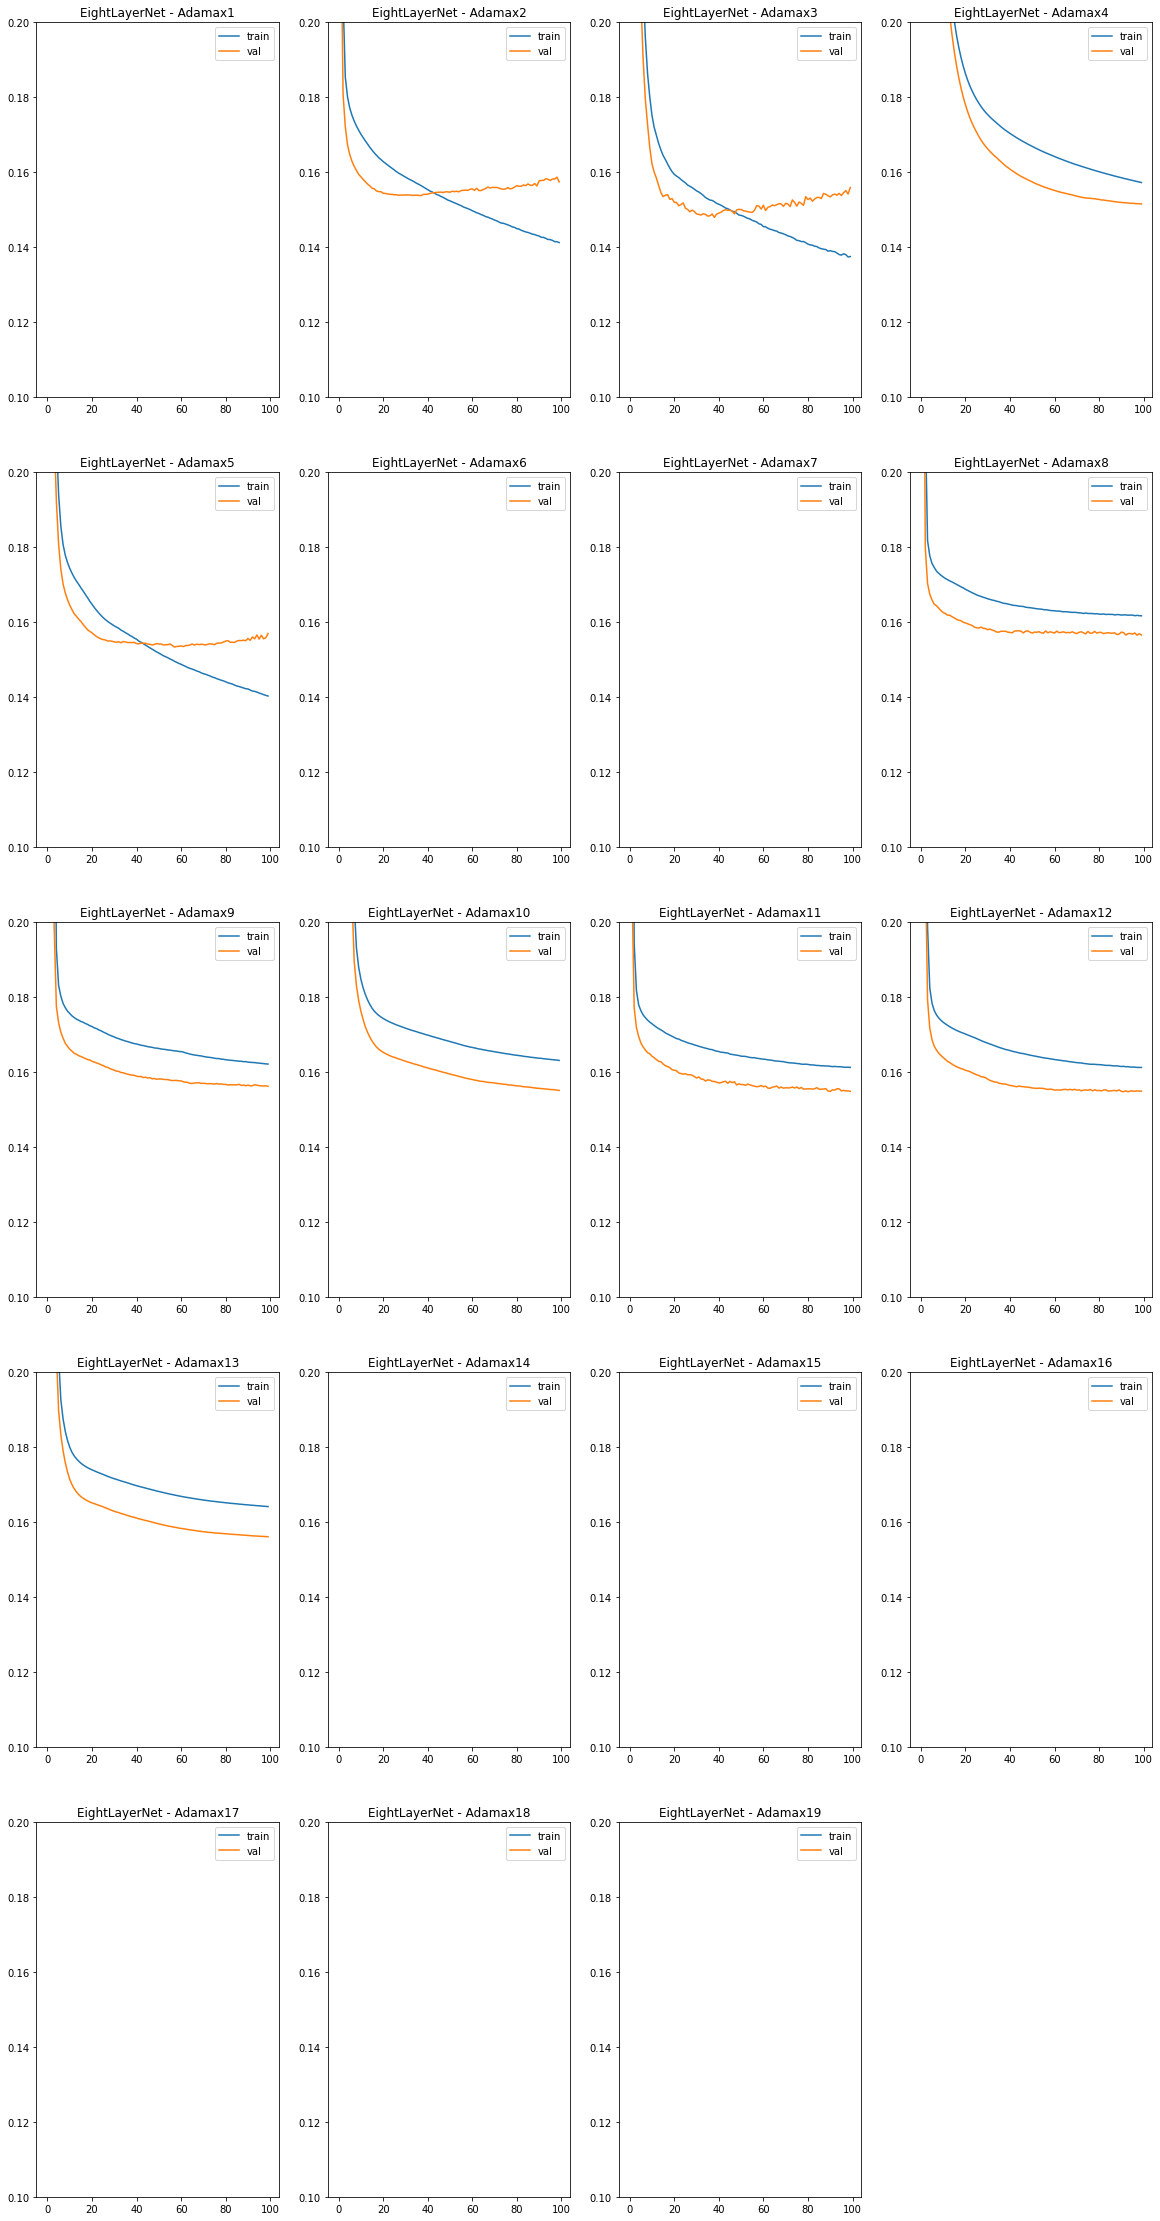

In [33]:
plot_losses(result)

In [35]:
df = get_df_from_results(result)
df.sort_values("best val loss").head(10)

best train loss  best val loss  best epoch
model         optimiser                                            
EightLayerNet Adamax3           0.137421       0.147984        38.0
              Adamax4           0.157288       0.151568        99.0
              Adamax5           0.140317       0.153385        57.0
              Adamax2           0.141277       0.153789        37.0
              Adamax12          0.161242       0.154744        93.0
              Adamax11          0.161252       0.154845        90.0
              Adamax10          0.163116       0.155120        99.0
              Adamax13          0.164110       0.156070        99.0
              Adamax9           0.162147       0.156222        99.0
              Adamax8           0.161715       0.156555        97.0

We need to run it for more epochs !

In [44]:
models = [EightLayerNet]
optims = [  (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),  #2 ->1
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),   #3 ->2
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0}), #4 ->3
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),   #5 ->4
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),  #8 ->5
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),   #9 ->6
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.01}), #10 ->7
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),   #11 ->8
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),    #12 ->9
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.01}),  #13 ->10
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),  #2 ->1 #Again to have at least one working
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0}),   #3 ->2
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0}), #4 ->3
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0}),   #5 ->4
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),  #8 ->5
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.85, 0.999), "eps":1e-08, "weight_decay":0.01}),   #9 ->6
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.85, 0.9999), "eps":1e-08, "weight_decay":0.01}), #10 ->7
            (torch.optim.Adamax, {"lr":0.0015, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),   #11 ->8
            (torch.optim.Adamax, {"lr":0.001, "betas":(0.8, 0.999), "eps":1e-08, "weight_decay":0.01}),    #12 ->9
            (torch.optim.Adamax, {"lr":0.0005, "betas":(0.8, 0.9999), "eps":1e-08, "weight_decay":0.01}),  #13 ->10
            ]
result = testing_all_models(models, optims, 200, id=True)
save_object(result, f"result_8Layer_Adamax_200epochs") #Save result object for analysis later on.

EightLayerNet - Adamax1 : [0.12337341 0.15324084]
EightLayerNet - Adamax2 : [0.13426846 0.14991743]
EightLayerNet - Adamax3 : [0.3124722  0.29732724]
EightLayerNet - Adamax4 : [0.13205843 0.1532238 ]
EightLayerNet - Adamax5 : [0.1600609  0.15455372]
EightLayerNet - Adamax6 : [0.31255596 0.29738266]
EightLayerNet - Adamax7 : [0.31250878 0.29732414]
EightLayerNet - Adamax8 : [0.15966581 0.15326278]


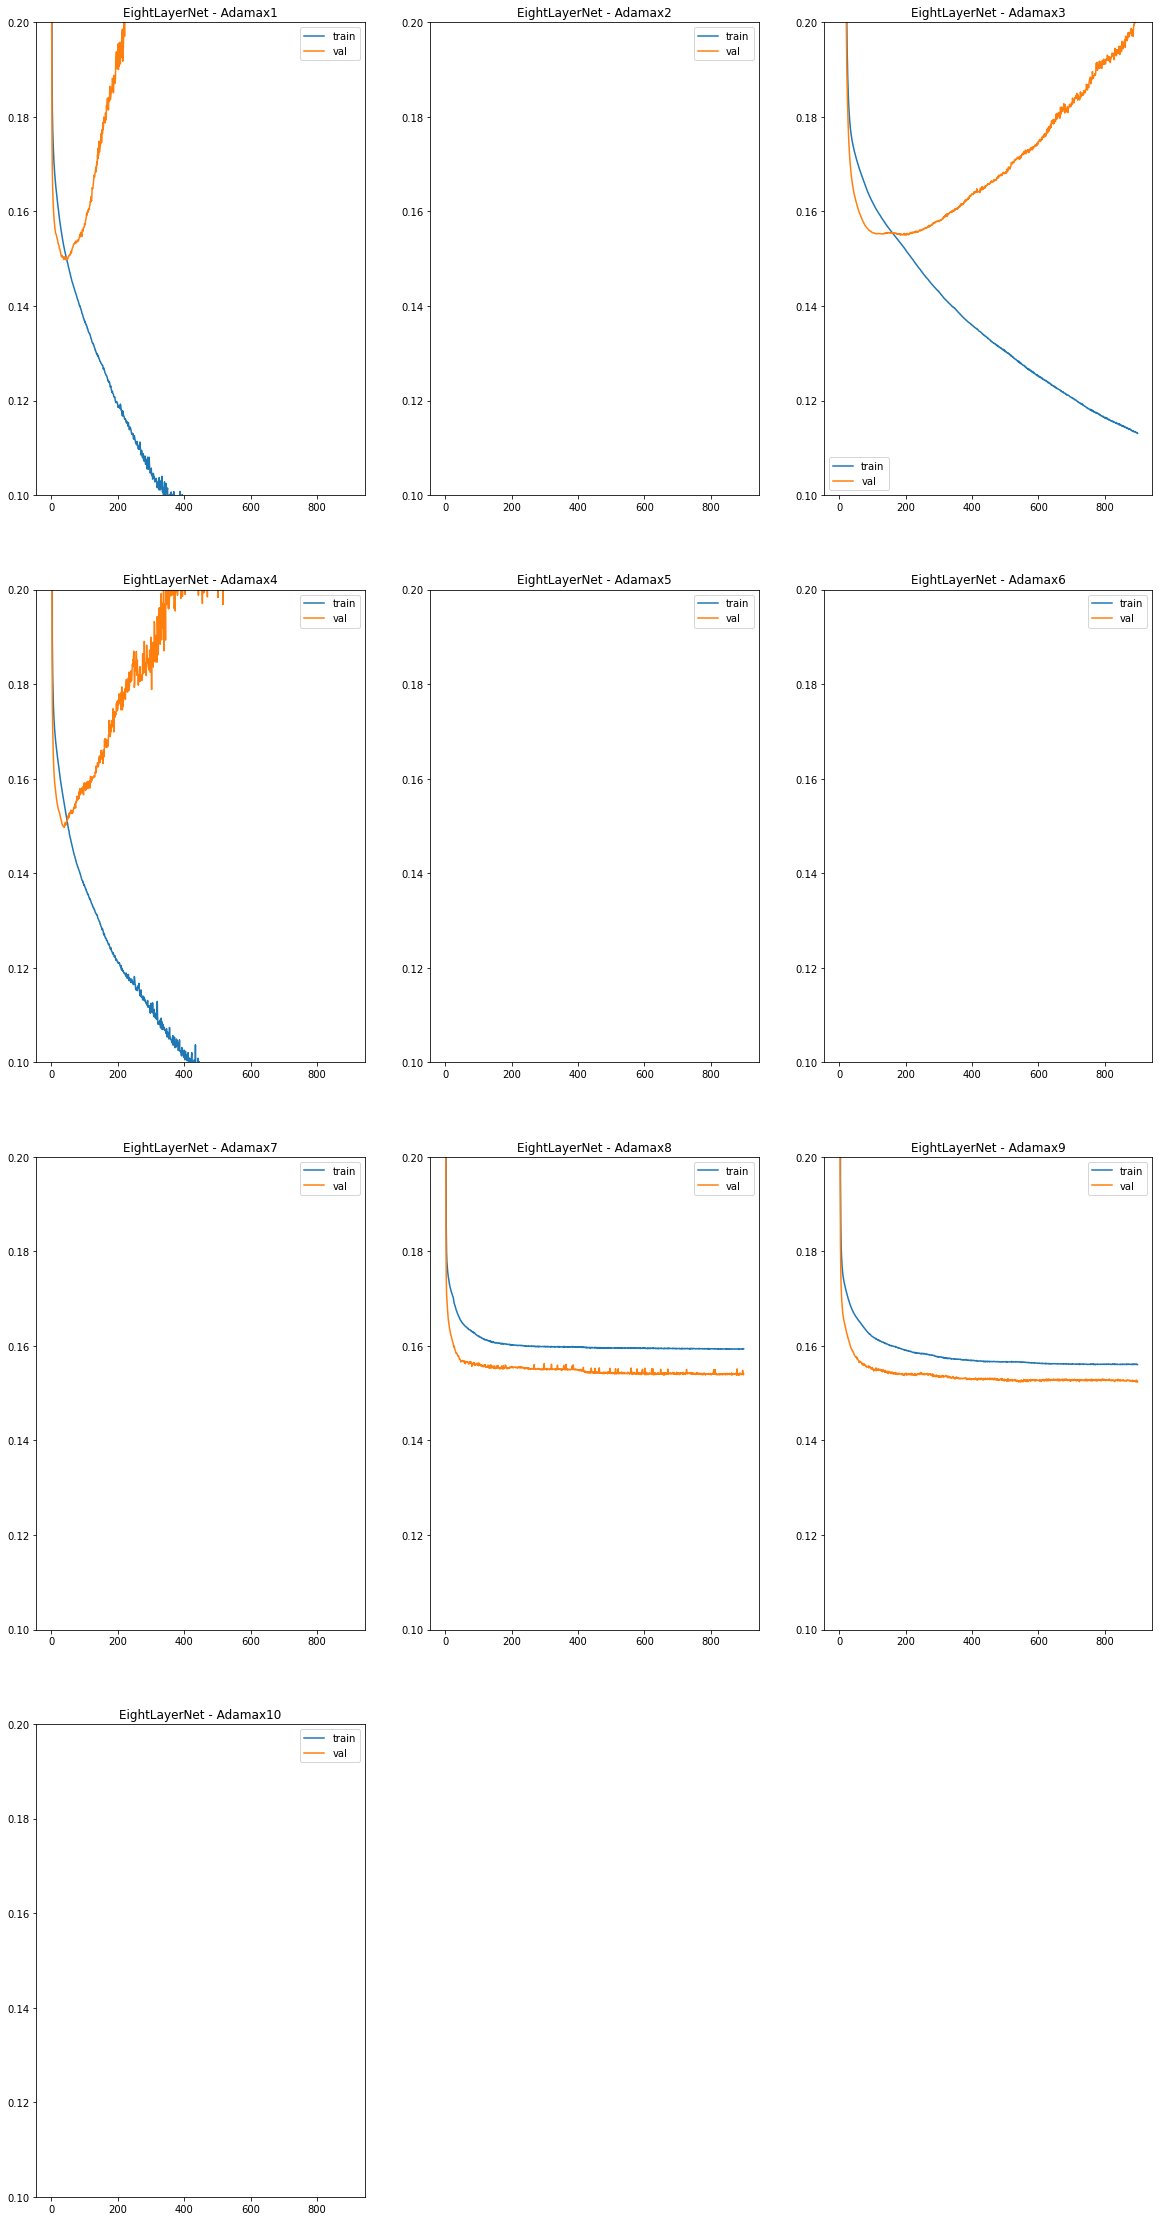

In [37]:
plot_losses(result)

#### B. Models who needed more epoch

## 4. Test on validation

In [ ]:
val_loss = test(model, dataload_val)
val_loss

0.16464586187154054

## 5. Export Results

In [ ]:
export_test()

### 6. Saving results for future purpose


In [ ]:
f= open("history.txt", "a+")
f.write(f"""
------------

{model}

Columns : {columns}
VAL LOSS : {val_loss}""")
f.close()

## 7. Exploring weights : identifying which cols are used

In [ ]:
weightss = torch.Tensor(list(one_layer_net.parameters())[0]).detach().numpy().reshape((-1))
print(weightss)
print(cols_map[np.argsort(np.abs(weightss))])
print(cols_map[np.argsort(weightss)])

[ 4.89094518e-02  1.60084367e-02 -2.99319699e-02 -8.15291852e-02
  6.07623123e-02 -6.49279952e-02  4.85553816e-02  5.62836509e-03
  3.26744094e-02  8.44709203e-03 -6.66475818e-02  2.06933171e-02
 -4.77486402e-02  5.48647456e-02  5.33154309e-02  1.52440378e-02
 -3.87026637e-04 -8.06853771e-02  5.62873706e-02  1.34960981e-02
 -4.31915820e-02 -4.82743699e-03 -6.04452658e-03 -2.33050920e-02
  7.61467144e-02 -5.38492650e-02 -4.01889682e-02  5.47575504e-02
 -6.48575090e-03 -1.81960166e-02 -2.60743331e-02  4.80739819e-03
  4.69803140e-02  6.28506318e-02 -1.28388451e-02 -3.03264260e-02
  8.63663014e-03  4.29149764e-03  5.32592274e-02 -6.76814541e-02
  1.20348493e-02 -4.98800166e-03  2.73799691e-02  3.26566100e-02
  4.12144847e-02 -4.27700616e-02 -3.59871611e-02  1.86313335e-02
  4.96571958e-02  4.93984185e-02 -2.62209494e-02 -6.89967796e-02
  8.12606364e-02  8.00067838e-03  3.11100036e-02  9.15166643e-03
  4.64990083e-03  4.19492237e-02 -1.76704526e-02  3.52022611e-02
  1.71438996e-02 -3.01328

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=493ee647-e437-4c81-80f8-96d4eefd9c39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>